# Evaluate the 100 sessions

### Evaluate each session separately


In [14]:
fr = np.load(os.path.join('/expanse/lustre/scratch/zwang34/temp_project/fr', '7cb81727-2097-4b52-b480-c89867b5b34c.npy'), allow_pickle=True)

(422,)

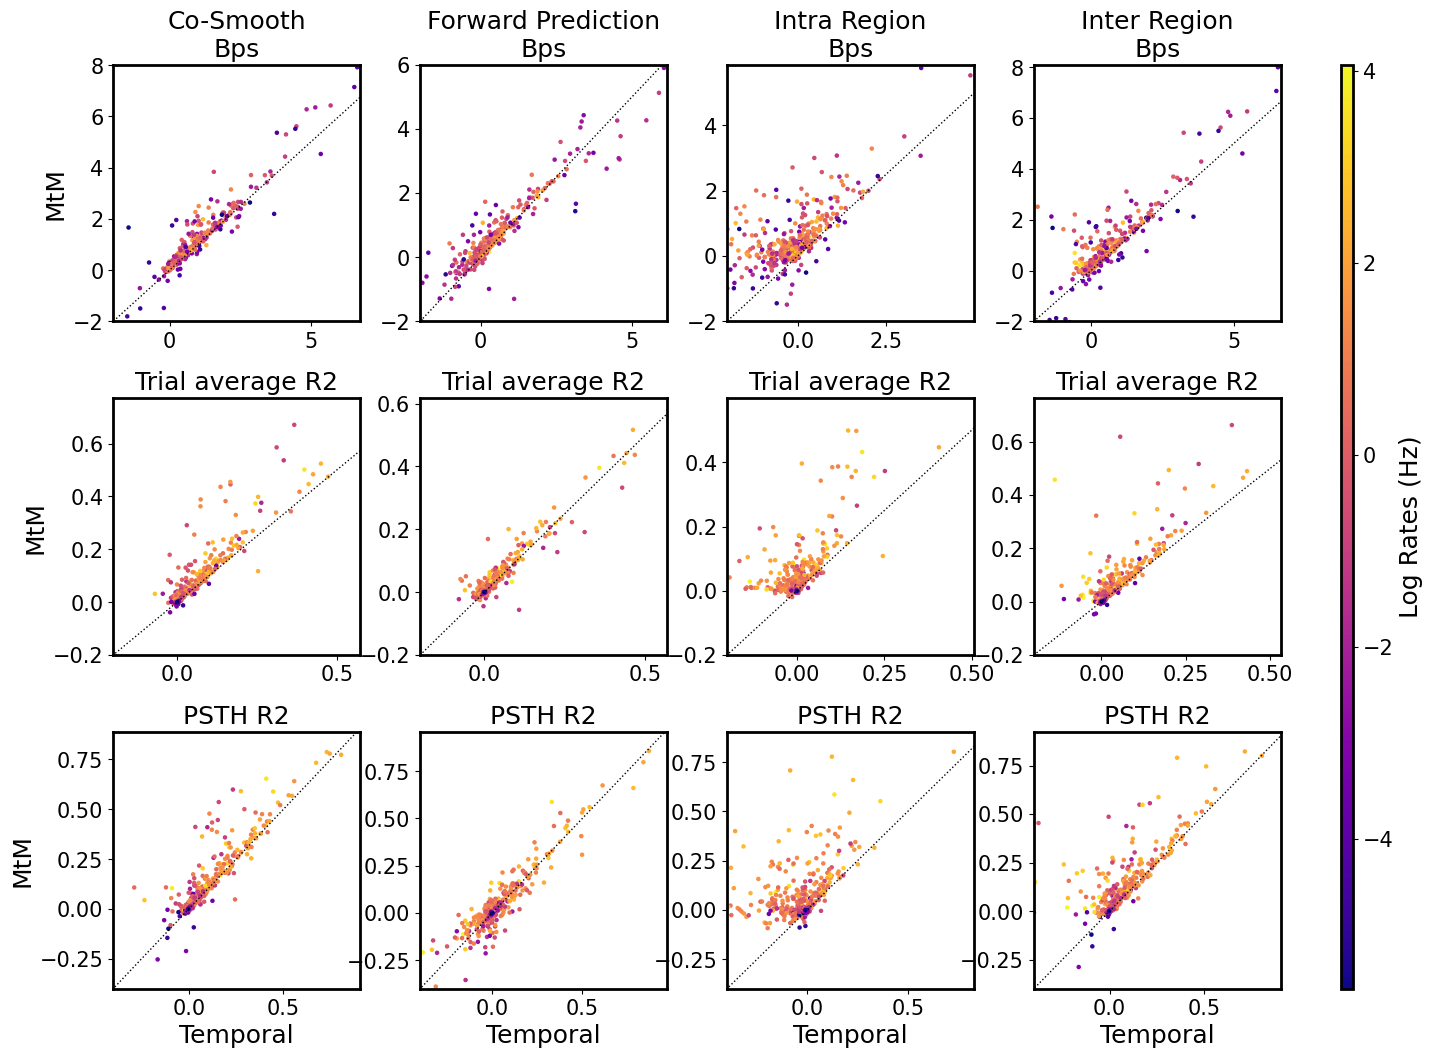

In [84]:
# scatter plot (all_prompt vs. temporal baseline)
import matplotlib.pyplot as plt
import numpy as np
import os

plt.rc("figure", dpi=100)
SMALL_SIZE = 3
BIGGER_SIZE = 15
plt.rc('font', size=10)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=3)
# plt.rc('figure', titlesize=3)

base_pt = '/expanse/lustre/scratch/zwang34/temp_project'

with open('/home/zwang34/IBL/ibl_foundation_model/IBL_foundation_model/data/target_eids.txt', 'r') as file:
    session_eids = [line.strip() for line in file.readlines()]

metrics = ['bps', 'r2_trial', 'r2_psth'] # bps / r2_trial / r2_psth

model_name = 'NDT1'
model_list = ['temporal', 'all']
model_list_ex = ['False', 'True']

ssl_list = ['co_smooth', 'forward_pred', 'intra_region', 'inter_region']
sl_list = ['choice_decoding', 'continuous_decoding']

TASK2NAME = {
    'co_smooth': 'Co-Smooth',
    'forward_pred': 'Forward Prediction',
    'intra_region': 'Intra Region',
    'inter_region': 'Inter Region',
}

METRIC2NAME = {
    'bps': 'Bps',
    'r2_trial': "Trial average R2",
    'r2_psth': "PSTH R2"
}

# session_eids = session_eids[0:10]
session_eids = ['7cb81727-2097-4b52-b480-c89867b5b34c']

n_session = len(session_eids)
n_task = len(ssl_list)

results = {}

fr = np.load(os.path.join('/expanse/lustre/scratch/zwang34/temp_project/fr', '7cb81727-2097-4b52-b480-c89867b5b34c.npy'), allow_pickle=True)
fr = fr*50

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 5, width_ratios=[10, 10, 10, 10, 0.5], height_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)

cax = fig.add_subplot(gs[:, 4])

for k, metric in enumerate(metrics):

    
    
    # for all session together plot
    ssl_results = {'co_smooth': [], 'forward_pred': [], 'intra_region': [], 'inter_region': []}
    sl_results = {'choice_decoding': [], 'continuous_decoding': []}
    
    for i, eid in enumerate(session_eids):
        
        for j, task in enumerate(ssl_list + sl_list):
            if j < len(ssl_list):
                ax = fig.add_subplot(gs[k, j]) 
                mc = []
                
                for model, if_prompt in zip(model_list, model_list_ex):
        
                    path = os.path.join(
                        base_pt,
                        'results',
                        eid,
                        'eval',
                        f'model_{model_name}',
                        'method_ssl',
                        f'mask_{model}',
                        'ratio_0.3/mask_token_False',
                        f'prompt_{if_prompt}',
                        task
                    )
        
                    if metric == 'r2_psth':
                        mc.append(np.load(os.path.join(path, 'r2.npy'))[:, 0])
                    elif metric == 'r2_trial':
                        mc.append(np.load(os.path.join(path, 'r2.npy'))[:, 1])
                    else:
                        mc.append(np.load(os.path.join(path, 'bps.npy')))
                
                ssl_results[task].append((np.nanmean(mc[0]), np.nanmean(mc[1])))

                _zero = (fr==0)
                mc[0] = mc[0][~_zero]
                mc[1] = mc[1][~_zero]
                tfr = np.log(fr[~_zero])
                # tfr = fr[~_zero]
                
                scatter = ax.scatter(mc[0], mc[1], s=5, c=tfr, cmap='plasma')
                x = np.linspace(-10, 10, 1000)
                ax.plot(x, x, ls=':', c='k', lw=1)
                if j == 0:
                    ax.set_ylabel("MtM")
                if k == 2:
                    ax.set_xlabel('Temporal')
                # ax.set_title('eid: {} \n {} \n temporal mean:{:.2f}, all mean:{:.2f}'.format(eid[:5], task, np.nanmean(mc[0]), np.nanmean(mc[1])))
                if metric == 'bps':
                    ax.set_title(TASK2NAME[task] + '\n' + METRIC2NAME[metric])
                else:
                    ax.set_title(METRIC2NAME[metric])
                cbar = fig.colorbar(scatter, cax=cax)
                cbar.set_label('Log Rates (Hz)')
            
                # ax.set_xlim(np.nanmin(mc[0])-0.1, np.nanmax(mc[0])+0.1)
                # ax.set_ylim(np.nanmin(mc[1])-0.1, np.nanmax(mc[1])+0.1)
                if metric == 'bps':
                    ax.set_xlim(-2, np.nanmax(mc[0])+0.1)
                    ax.set_ylim(-2, np.nanmax(mc[1])+0.1)
                elif metric == 'r2_psth':
                    ax.set_xlim(-0.4, np.nanmax(mc[0])+0.1)
                    ax.set_ylim(-0.4, np.nanmax(mc[1])+0.1)
                else:
                    ax.set_xlim(-0.2, np.nanmax(mc[0])+0.1)
                    ax.set_ylim(-0.2, np.nanmax(mc[1])+0.1)
            
            else:
                x = []
                for model, if_prompt in zip(model_list, model_list_ex):
        
                    path = os.path.join(
                        base_pt,
                        'results',
                        eid,
                        'eval',
                        f'model_{model_name}',
                        'method_ssl',
                        f'mask_{model}',
                        'ratio_0.3/mask_token_False',
                        f'prompt_{if_prompt}',
                        task
                    )
    
                    
                    if task == 'choice_decoding':
                        # print(eid[:5], 'choice', model, np.load(os.path.join(path, 'choice_results.npy'), allow_pickle=True))
                        x.append(np.load(os.path.join(path, 'choice_results.npy'), allow_pickle=True).item()['acc'])
                    elif task == 'continuous_decoding':
                        # print(eid[:5], 'whisker-motion-energy', model, np.load(os.path.join(path, 'whisker-motion-energy_results.npy'), allow_pickle=True))
                        x.append(np.load(os.path.join(path, 'whisker-motion-energy_results.npy'), allow_pickle=True).item()['rsquared'])
                    
                sl_results[task].append((x[0], x[1]))     
    
    # plt.tight_layout()
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.15, wspace=0.3, hspace=0.4)
fig.savefig(os.path.join(f'/home/zwang34/IBL/ibl_foundation_model/IBL_foundation_model/per_neuron_metric.pdf'))
ssl_results.update(sl_results)
results[metric] = ssl_results
    

### Evaluate all sessions together

In [9]:
import pandas as pd

df = {}

for metric in metrics:
    data = results[metric]
    for key in data:
        data[key] = [tuple(f"{x:.2f}" if isinstance(x, float) else x for x in tup) for tup in data[key]]
    df[metric] = pd.DataFrame(data)
    
    df[metric].insert(0, 'EID', session_eids)


In [10]:
df['r2_psth']

,EID,co_smooth,forward_pred,intra_region,inter_region,choice_decoding,continuous_decoding
0,7cb81727-2097-4b52-b480-c89867b5b34c,"(0.08, 0.11)","(0.01, -0.00)","(-0.08, 0.06)","(0.05, 0.10)","(0.66, 0.63)","(0.56, 0.61)"


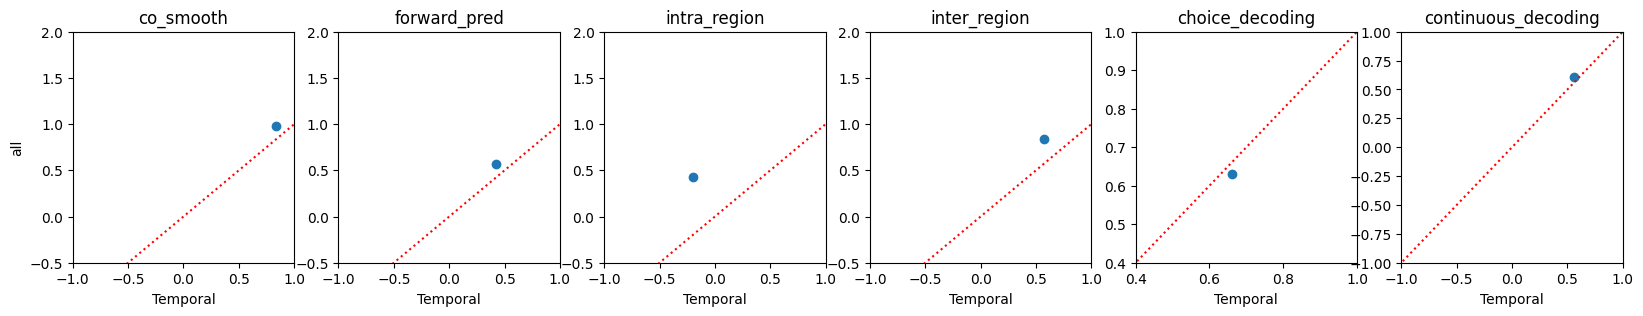

In [11]:
fig = plt.figure(figsize=(20,3))

ssl_results = results['bps']

for i, (k, v) in enumerate((ssl_results).items()):
        ax = fig.add_subplot(1, len(ssl_list+sl_list), i+1)
        ax.scatter(np.array(v)[:, 0].astype(float), np.array(v)[:, 1].astype(float))
        ax.set_title(k)
        x = np.linspace(-5, 5)
        ax.plot(x, x, ls=':', c='r')
        ax.set_xlabel('Temporal')
        
        if i == 0:
           ax.set_ylabel('all')
        if 0<=i<=3:
            ax.set_xlim([-1, 1])
            ax.set_ylim([-0.5, 2])
        if i == 4:
            ax.set_xlim([.4, 1])
            ax.set_ylim([.4, 1])
        if i == 5:
            ax.set_xlim([-1, 1])
            ax.set_ylim([-1, 1])
        
        #ax.set_xlim(-1, 1)
        #ax.set_ylim(np.array(v)[:, 1].min(), np.array(v)[:, 1].max())

### Obtain the mean_fr & quality for each session

In [ ]:
import argparse
from datasets import load_dataset, load_from_disk, concatenate_datasets
from utils.dataset_utils import load_ibl_dataset
from loader.make_loader import make_loader
from utils.utils import set_seed
from utils.config_utils import config_from_kwargs, update_config
import torch
import numpy as np
import os
from utils.eval_utils import load_model_data_local, co_smoothing_eval, behavior_decoding
import warnings
warnings.simplefilter("ignore")


with open('/home/zwang34/IBL/ibl_foundation_model/IBL_foundation_model/data/target_eids.txt', 'r') as file:
    session_eids = [line.strip() for line in file.readlines()]

config = config_from_kwargs({"model": f"include:/home/zwang34/IBL/ibl_foundation_model/IBL_foundation_model/src/configs/ndt1_causal_eval.yaml"})
config = update_config('/home/zwang34/IBL/ibl_foundation_model/IBL_foundation_model/src/configs/trainer_ndt1.yaml', config)

# print(config)
for eid in session_eids:
    _,_,_, meta_data = load_ibl_dataset(
                            cache_dir=config.dirs.dataset_cache_dir,
                            user_or_org_name=config.dirs.huggingface_org,
                            num_sessions=1,
                            split_method="predefined",
                            test_session_eid=[],
                            batch_size=config.training.train_batch_size,
                            seed=42,
                            eid=eid
                        )
    # print(meta_data)
    dataset = load_dataset(f'neurofm123/{eid}_aligned', cache_dir=config.dirs.dataset_cache_dir)["test"]
    n_neurons = len(dataset['cluster_regions'][0])
    max_space_length = n_neurons if config.model.model_class in ["NDT1", "iTransformer"] else config.data.max_space_length
    
    dataloader = make_loader(
            dataset,
            target=config.data.target,
            batch_size=len(dataset),
            pad_to_right=True,
            pad_value=-1.,
            max_time_length=config.data.max_time_length,
            max_space_length=max_space_length,
            dataset_name=config.data.dataset_name,
            load_meta=config.data.load_meta,
            shuffle=False,
        )
    for batch in dataloader:
        break
    
    mean_fr = batch['spikes_data'].mean((0,1)).numpy()
    print(mean_fr.shape)
    np.save(os.path.join('/expanse/lustre/scratch/zwang34/temp_project/fr', eid+'.npy'), mean_fr)


In [27]:
x = np.load('/expanse/lustre/scratch/zwang34/temp_project/results/03d9a098-07bf-4765-88b7-85f8d8f620cc/eval/model_NDT1/method_ssl/mask_all/ratio_0.3/mask_token_False/prompt_True/continuous_decoding/whisker-motion-energy_results.npy', allow_pickle=True)

In [28]:
x

array({'rsquared': 0.17823490186741478}, dtype=object)